In [2]:
from typing import Dict, List
import datetime

class Position:
    def __init__(self, 
                 security: str, 
                 price: float=0, 
                 acc_avg_cost: float=0, 
                 avg_cost: float=0, 
                 hold_cost: float=0, 
                 init_time: datetime.datetime=datetime.datetime.now(), 
                 transact_time: datetime.datetime=datetime.datetime.now(), 
                 locked_amount: float=0, 
                 total_amount: float=0, 
                 closeable_amount: float=0, 
                 today_amount: float=0, 
                 value: float=0, 
                 side: str='long'):
        self.security = security
        self.price = price
        self.acc_avg_cost = acc_avg_cost
        self.avg_cost = avg_cost
        self.hold_cost = hold_cost
        self.init_time = init_time
        self.transact_time = transact_time
        self.locked_amount = locked_amount
        self.total_amount = total_amount
        self.closeable_amount = closeable_amount
        self.today_amount = today_amount
        self.value = value
        self.side = side

class Portfolio:
    def __init__(self, 
                 inout_cash: float, 
                 available_cash: float, 
                 transferable_cash: float, 
                 locked_cash: float,
                 positions: Dict[str, Position], 
                 returns: float, 
                 starting_cash: float, 
                 positions_value: float):
        self.inout_cash = inout_cash
        self.available_cash = available_cash
        self.transferable_cash = transferable_cash
        self.locked_cash = locked_cash
        self.positions = positions
        self.long_positions = {k:v for k,v in positions.items() if v.side == 'long'}
        self.short_positions = {k:v for k,v in positions.items() if v.side == 'short'}
        self.returns = returns
        self.starting_cash = starting_cash
        self.positions_value = positions_value
        self.total_value = starting_cash + inout_cash + positions_value
        
    def position(self, security: str) -> Position:
        return self.positions[security]



# 测试用
# # 创建一个空的Portfolio对象
# portfolio = Portfolio(0.0, 10000.0, 10000.0, 0.0, {}, 0.0, 10000.0, 0.0)

# # 添加一个持仓
# position = Position('AAPL', 120.0, 119.5, 121.0, 122.0, datetime.datetime.now(), datetime.datetime.now(), 
#                      0.0, 100.0, 100.0, 0.0, 12000.0, 'long')
# portfolio.positions['AAPL'] = position

# # 访问属性和方法
# print("累计出入金:{0}".format(portfolio.inout_cash))
# print("可用资金:{0}".format(portfolio.available_cash))
# print("可取资金:{0}".format(portfolio.transferable_cash))
# print("挂单锁住资金:{0}".format(portfolio.locked_cash))

# print("多单的仓位:{0}".format(portfolio.long_positions)) 
# print("空单的仓位:{0}".format(portfolio.short_positions))
# print("总权益:{0}".format(portfolio.total_value))

# print(type(portfolio.long_positions))
# long_positions_dict = portfolio.long_positions
# for position in list(long_positions_dict.values()):  
#     print("标的:{0},总仓位:{1},标的价值:{2}, 建仓时间:{3}".format(position.security, position.total_amount, 
#                                                            position.value, position.init_time))


In [3]:
# 上下文数据
class Context:
    def __init__(self, cash, start_date, end_date):
        # 资金
        self.cash = cash
        # 开始时间
        self.start_date = start_date
        # 结束时间
        self.end_date = end_date
        # 持仓标的信息
        self.positions = {}
        # 基准
        self.benchmark = None
        # 交易日期
        self.date_range = trade_cal[(trade_cal['trade_date'] >= start_date) &
                                    (trade_cal['trade_date'] <= end_date)]['trade_date'].values
        # 回测今天日期
        self.dt = dateutil.parser.parse(start_date)
        # self.portfolio = Portfolio()
        self.portfolio = Portfolio(0.0, 10000.0, 10000.0, 0.0, {}, 0.0, 10000.0, 0.0)



# 全局变量用
class G:
    pass


# 全局变量用
g = G()

In [4]:
# 简单回测框架(仿聚宽），使用akshare

import datetime
import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import dateutil
import numpy as np
import akshare as ak
import math




# 获取各大交易所交易日历数据
def ak_trade_cal():
    df = ak.tool_trade_date_hist_sina()
    # print(df)
    # 转换为日期格式
    df['trade_date'] = pd.to_datetime(df['trade_date'])
    # 设置'trade_date'为索引
    # df.set_index('trade_date', inplace=True)
    # 存储为csv文件
    # df.to_csv('./trade_cal.csv')
    return df

# 下载并保存交易日历数据
trade_cal = ak_trade_cal()


# 实例化上下文数据Context
context = Context(cash=100000, start_date='2023-01-01', end_date='2023-06-01')


def ak_daily(security, start_date, end_date, fields=('open', 'close', 'high', 'low', 'volume')):
    # print('security', security)
    # print('start_date', start_date)
    # print('end_date', end_date)

    # df = ak.stock_zh_a_daily(symbol=security, start_date=start_date, end_date=end_date, adjust="qfq")
    df = ak.fund_etf_hist_em(symbol=security, start_date=start_date, end_date=end_date, adjust='qfq').rename(
        columns={
            "日期": "date",
            "开盘": "open",
            "收盘": "close",
            "最高": "high",
            "最低": "low",
            "成交量": "volume",
        }
    )

    # 转换为日期格式
    df['date'] = pd.to_datetime(df['date'])
    # 设置'date'为索引
    df.set_index('date', inplace=True)
    return df[list(fields)]



# 设置基准
def set_bench_mark(security):
    context.benchmark = security


# 获取历史数据
def attribute_history(security, count, fields=('open', 'close', 'high', 'low', 'volume')):
    end_date = (context.dt - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    start_date = trade_cal[(trade_cal['trade_date'] <= end_date)][-count:].iloc[0, :][
        'trade_date'].strftime('%Y-%m-%d')
    return attribute_daterange_history(security, start_date, end_date, fields)


# 获取历史数据基础函数
def attribute_daterange_history(security, start_date, end_date, fields=('open', 'close', 'high', 'low', 'volume')):
    # 尝试读取本地数据
    # 2022-10-18 转换为 20221018
    time_array1 = time.strptime(start_date, '%Y-%m-%d')
    start_date = time.strftime('%Y%m%d', time_array1)
    time_array2 = time.strptime(end_date, '%Y-%m-%d')
    end_date = time.strftime('%Y%m%d', time_array2)
    df = ak_daily(security, start_date, end_date)

    return df[list(fields)]


# 今天日线行情
def get_today_data(security, fields=('open', 'close', 'high', 'low', 'volume')):
    today = context.dt.strftime('%Y%m%d')
    # df = ak.stock_zh_a_daily(symbol=security, start_date=today, end_date=today, adjust="qfq")
    df = ak.fund_etf_hist_em(symbol=security, start_date=today, end_date=today, adjust='qfq').rename(
        columns={
            "日期": "date",
            "开盘": "open",
            "收盘": "close",
            "最高": "high",
            "最低": "low",
            "成交量": "volume",
        }
    )
    # print('today_df', df.head())
    # 转换为日期格式
    df['date'] = pd.to_datetime(df['date'])
    # 设置'date'为索引
    df.set_index('date', inplace=True)
    return df[list(fields)]


# def get_realtime_quotes():
#     data = ak.stock_zh_a_spot_em()
#     return data


# 买卖订单基础函数
def _order(today_data, security, amount):
    # 股票价格
    p = today_data['open'].values[0]
    # 停牌
    if len(today_data) == 0:
        print("今日停牌")
        return
    # 现金不足
    if context.portfolio.available_cash - amount * p < 0:
        amount = int(context.portfolio.available_cash / p / 100) * 100
        print("现金不足,已调整为%d" % amount)
    # 100的倍数
    if amount % 100 != 0:
        if amount != -context.portfolio.positions.get(security).total_amount:
            amount = int(amount / 100) * 100
            print("不是100的倍数,已调整为%d" % amount)
    # 卖出数量超过持仓数量
    if context.portfolio.positions.get(security).total_amount < -amount:
        amount = -context.portfolio.positions.get(security).total_amount
        print("卖出数量不能超过持仓数量,已调整为%d" % amount)
    # 将买卖股票数量存入持仓标的信息
    context.portfolio.positions.get(security).total_amount = context.portfolio.positions.get(security).total_amount + amount
    print('剩余持仓', context.portfolio.positions.get(security).total_amount)
    # 剩余资金
    context.portfolio.available_cash -= amount * p
    print('剩余资金', context.portfolio.available_cash)

    # 如果一只股票持仓为0，则删除上下文数据持仓标的信息中该股信息
    if context.portfolio.positions.get(security).total_amount == 0:
        context.portfolio.positions.get(security).total_amount = 0


# 按股数下单
def order(security, amount):
    today_data = get_today_data(security)
    _order(today_data, security, amount)


# 目标股数下单
def order_target(security, amount):
    if amount < 0:
        print("数量不能为负，已调整为0")
        amount = 0
    today_data = get_today_data(security)
    hold_amount = context.positions.get(security, 0)
    delta_amount = amount - hold_amount
    _order(today_data, security, delta_amount)


# 按价值下单
def order_value(security, value):
    today_data = get_today_data(security)
    amount = int(value / today_data['open'].values[0])
    _order(today_data, security, amount)


# 目标价值下单
def order_target_value(security, value):
    if value < 0:
        print("价值不能为负，已调整为0")
        value = 0
    today_data = get_today_data(security)
    hold_value = context.portfolio.positions.get(security).total_amount * today_data['open'].values[0]
    print('hold_value', hold_value)
    delta_value = value - hold_value
    print('delta_value', delta_value)

    order_value(security, delta_value)



In [5]:
# 策略部分



#2-1 择时模块-计算线性回归统计值
#对输入的自变量每日最低价x(series)和因变量每日最高价y(series)建立OLS回归模型,返回元组(截距,斜率,拟合度)
def get_ols(x, y):
    slope, intercept = np.polyfit(x, y, 1)
    r2 = 1 - (sum((y - (slope * x + intercept))**2) / ((len(y) - 1) * np.var(y, ddof=1)))
    return (intercept, slope, r2)


#2-2 择时模块-设定初始斜率序列
#通过前M日最高最低价的线性回归计算初始的斜率,返回斜率的列表
def initial_slope_series():
    data = attribute_history(g.ref_stock, g.N + g.M, ['high', 'low'])
    return [get_ols(data.low[i:i+g.N], data.high[i:i+g.N])[1] for i in range(g.M)]


#2-3 择时模块-计算标准分
#通过斜率列表计算并返回截至回测结束日的最新标准分
def get_zscore(slope_series):
    mean = np.mean(slope_series)
    std = np.std(slope_series)
    return (slope_series[-1] - mean) / std

#1-1 选股模块-动量因子轮动 
#基于股票年化收益和判定系数打分,并按照分数从大到小排名
def get_rank():
    score_list = []
    for stock in g.stock_pool:
        data = attribute_history(stock, g.momentum_day, ['close'])
        y = data['log'] = np.log(data.close)
        x = data['num'] = np.arange(data.log.size)
        slope, intercept = np.polyfit(x, y, 1)
        annualized_returns = math.pow(math.exp(slope), 250) - 1
        r_squared = 1 - (sum((y - (slope * x + intercept))**2) / ((len(y) - 1) * np.var(y, ddof=1)))
        score = annualized_returns * r_squared
        score_list.append(score)
    stock_dict=dict(zip(g.stock_pool, score_list))
    sort_list=sorted(stock_dict.items(), key=lambda item:item[1], reverse=True) #True为降序
    code_list=[]
    for i in range((len(g.stock_pool))):
        code_list.append(sort_list[i][0])
    rank_stock = code_list[0:g.stock_num]
    return rank_stock


#2-4 择时模块-计算综合信号
#1.获得rsrs与MA信号,rsrs信号算法参考优化说明，MA信号为一段时间两个端点的MA数值比较大小
#2.信号同时为True时返回买入信号，同为False时返回卖出信号，其余情况返回持仓不变信号
def get_timing_signal(stock):
    #计算MA信号
    close_data = attribute_history(g.ref_stock, g.mean_day + g.mean_diff_day, ['close'])
    today_MA = close_data.close[g.mean_diff_day:].mean() 
    before_MA = close_data.close[:-g.mean_diff_day].mean()
    #计算rsrs信号
    high_low_data = attribute_history(g.ref_stock, g.N, ['high', 'low'])
    intercept, slope, r2 = get_ols(high_low_data.low, high_low_data.high)
    g.slope_series.append(slope)
    rsrs_score = get_zscore(g.slope_series[-g.M:]) * r2
    #综合判断所有信号
    if rsrs_score > g.score_threshold and today_MA > before_MA:
        print('BUY')
        return "BUY"
    elif rsrs_score < -g.score_threshold and today_MA < before_MA:
        print('SELL')
        return "SELL"
    else:
        print('KEEP')
        return "KEEP"



#4-1 交易模块-自定义下单
#报单成功返回报单(不代表一定会成交),否则返回None,应用于
def order_target_value_(security, value):
	if value == 0:
		print("Selling out %s" % (security))
	else:
		print("Order %s to value %f" % (security, value))
	# 如果股票停牌，创建报单会失败，order_target_value 返回None
	# 如果股票涨跌停，创建报单会成功，order_target_value 返回Order，但是报单会取消
	# 部成部撤的报单，聚宽状态是已撤，此时成交量>0，可通过成交量判断是否有成交
	return order_target_value(security, value)

#4-2 交易模块-开仓
#买入指定价值的证券,报单成功并成交(包括全部成交或部分成交,此时成交量大于0)返回True,报单失败或者报单成功但被取消(此时成交量等于0),返回False
def open_position(security, value):
	order = order_target_value_(security, value)
	if order != None and order.filled > 0:
		return True
	return False

#4-3 交易模块-平仓
#卖出指定持仓,报单成功并全部成交返回True，报单失败或者报单成功但被取消(此时成交量等于0),或者报单非全部成交,返回False
def close_position(position):
	security = position.security
	print('closing position')
	order = order_target_value_(security, 0)  # 可能会因停牌失败
	if order != None:
		if order.status == OrderStatus.held and order.filled == order.amount:
			return True
	return False

#4-4 交易模块-调仓
#当择时信号为买入时开始调仓，输入过滤模块处理后的股票列表，执行交易模块中的开平仓操作
def adjust_position(context, buy_stocks):
	for stock in context.portfolio.positions:
		print('stock', stock)
		print('buy_stocks', buy_stocks)
		if stock not in buy_stocks:
			print("[%s]已不在应买入列表中" % (stock))
			position = context.portfolio.positions[stock]
			close_position(position)
		else:
			print("[%s]已经持有无需重复买入" % (stock))
	# 根据股票数量分仓
	# 此处只根据可用金额平均分配购买，不能保证每个仓位平均分配
	# position_count = len(context.portfolio.positions)
	position_count = 0
	for k, v in context.portfolio.positions.items():
		if v.total_amount >0:
			position_count += 1

	print('position_count', position_count)
	if g.stock_num > position_count:
		value = context.portfolio.available_cash / (g.stock_num - position_count)
		
		for stock in buy_stocks:
			if context.portfolio.positions.get(stock, None) == None:
				context.portfolio.positions[stock] = Position(stock)
			print(context.portfolio.positions)
			if context.portfolio.positions[stock].total_amount == 0:
				print('enter open_position', value)
				if open_position(stock, value):
					if len(context.portfolio.positions) == g.stock_num:
						break

def handle_data(context):
    check_out_list = get_rank()
    print('今日自选股:{}'.format(check_out_list))
    #获取综合择时信号
    timing_signal = get_timing_signal(g.ref_stock)
    print('今日择时信号:{}'.format(timing_signal))
    #开始交易
    if timing_signal == 'SELL':
        for stock in context.portfolio.positions:
            position = context.portfolio.positions[stock]
            close_position(position)
    elif timing_signal == 'BUY' or timing_signal == 'KEEP':
        adjust_position(context, check_out_list)
    else:
        pass

今日自选股:['159919']
KEEP
今日择时信号:KEEP
position_count 0
{'159919': <__main__.Position object at 0x7f7d3b320a90>}
enter open_position 10000.0
Order 159919 to value 10000.000000
hold_value 0.0
delta_value 10000.0
不是100的倍数,已调整为2500
剩余持仓 2500
剩余资金 135.0


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['159919']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['159919']
[159919]已经持有无需重复买入
position_count 1
今日自选股:['159919']


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['159919']
[159919]已经持有无需重复买入
position_count 1
今日自选股:['159919']
SELL
今日择时信号:SELL
closing position
Selling out 159919
hold_value 10085.0
delta_value -10085.0
剩余持仓 0
剩余资金 10220.0
今日自选股:['159919']
SELL
今日择时信号:SELL
closing position
Selling out 159919


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10220.0
今日自选股:['159919']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['159919']
[159919]已经持有无需重复买入
position_count 0
{'159919': <__main__.Position object at 0x7f7d3b320a90>}
enter open_position 10220.0
Order 159919 to value 10220.000000


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


hold_value 0.0
delta_value 10220.0
不是100的倍数,已调整为2500
剩余持仓 2500
剩余资金 42.5
今日自选股:['159919']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['159919']
[159919]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['159919']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['159919']
[159919]已经持有无需重复买入
position_count 1
今日自选股:['159915']


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['159915']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 10240.0
delta_value -10240.0
剩余持仓 0
剩余资金 10282.5
position_count 0
{'159919': <__main__.Position object at 0x7f7d3b320a90>, '159915': <__main__.Position object at 0x7f7d3b338eb0>}
enter open_position 10282.5
Order 159915 to value 10282.500000
hold_value 0.0
delta_value 10282.5
不是100的倍数,已调整为4200
剩余持仓 4200
剩余资金 215.10000000000036


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['159915']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['159915']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 215.10000000000036
stock 159915
buy_stocks ['159915']
[159915]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['159915']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['159915']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 215.10000000000036
stock 159915
buy_stocks ['159915']
[159915]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['159915']
BUY
今日择时信号:BUY
stock 159919
buy_stocks ['159915']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 215.10000000000036
stock 159915
buy_stocks ['159915']
[159915]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['159915']
BUY
今日择时信号:BUY
stock 159919
buy_stocks ['159915']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 215.10000000000036
stock 159915
buy_stocks ['159915']
[159915]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['159915']
BUY
今日择时信号:BUY
stock 159919
buy_stocks ['159915']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 215.10000000000036
stock 159915
buy_stocks ['159915']
[159915]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['159915']
BUY
今日择时信号:BUY
stock 159919
buy_stocks ['159915']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 215.10000000000036
stock 159915
buy_stocks ['159915']
[159915]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['159915']
BUY
今日择时信号:BUY
stock 159919
buy_stocks ['159915']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 215.10000000000036
stock 159915
buy_stocks ['159915']
[159915]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['159915']
BUY
今日择时信号:BUY
stock 159919
buy_stocks ['159915']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 215.10000000000036
stock 159915
buy_stocks ['159915']
[159915]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['159915']
BUY
今日择时信号:BUY
stock 159919
buy_stocks ['159915']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 215.10000000000036
stock 159915
buy_stocks ['159915']
[159915]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['159915']
BUY
今日择时信号:BUY
stock 159919
buy_stocks ['159915']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 215.10000000000036
stock 159915
buy_stocks ['159915']
[159915]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['159915']
BUY
今日择时信号:BUY
stock 159919
buy_stocks ['159915']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 215.10000000000036
stock 159915
buy_stocks ['159915']
[159915]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['159915']
BUY
今日择时信号:BUY
stock 159919
buy_stocks ['159915']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 215.10000000000036
stock 159915
buy_stocks ['159915']
[159915]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['159915']
BUY
今日择时信号:BUY
stock 159919
buy_stocks ['159915']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 215.10000000000036
stock 159915
buy_stocks ['159915']
[159915]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['159915']
BUY
今日择时信号:BUY
stock 159919
buy_stocks ['159915']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 215.10000000000036
stock 159915
buy_stocks ['159915']
[159915]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['159915']
BUY
今日择时信号:BUY
stock 159919
buy_stocks ['159915']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 215.10000000000036
stock 159915
buy_stocks ['159915']
[159915]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['159915']
BUY
今日择时信号:BUY
stock 159919
buy_stocks ['159915']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 215.10000000000036
stock 159915
buy_stocks ['159915']
[159915]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['159915']
BUY
今日择时信号:BUY
stock 159919
buy_stocks ['159915']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 215.10000000000036
stock 159915
buy_stocks ['159915']
[159915]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 215.10000000000036
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 10449.6
delta_value -10449.6
剩余持仓 0
剩余资金 10664.7
position_count 0
{'159919': <__main__.Position object at 0x7f7d3b320a90>, '159915': <__main__.Position object at 0x7f7d3b338eb0>, '513100': <__main__.Position object at 0x7f7d929f5ed0>}
enter open_position 10664.7
Order 513100 to value 10664.700000
hold_value 0.0
delta_value 10664.7
不是100的倍数,已调整为12100
剩余持仓 12100
剩余资金 77.20000000000073


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 77.20000000000073
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 77.20000000000073
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 77.20000000000073
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 77.20000000000073
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 77.20000000000073
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 77.20000000000073
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 77.20000000000073
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 77.20000000000073
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 77.20000000000073
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 77.20000000000073
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 77.20000000000073
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 77.20000000000073
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
SELL
今日择时信号:SELL
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 77.20000000000073
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 77.20000000000073
closing position
Selling out 513100
hold_value 10406.0
delta_value -10406.0
剩余持仓 0
剩余资金 10483.2


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
SELL
今日择时信号:SELL
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
closing position
Selling out 513100
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
SELL
今日择时信号:SELL
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
closing position
Selling out 513100
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
SELL
今日择时信号:SELL
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
closing position
Selling out 513100
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
SELL
今日择时信号:SELL
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
closing position
Selling out 513100
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['510500']
SELL
今日择时信号:SELL
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
closing position
Selling out 513100
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
今日自选股:['510500']


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


SELL
今日择时信号:SELL
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
closing position
Selling out 513100
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['510500']
SELL
今日择时信号:SELL
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
closing position
Selling out 513100
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
今日自选股:['510500']


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


SELL
今日择时信号:SELL
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
closing position
Selling out 513100
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['510500']
SELL
今日择时信号:SELL
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
closing position
Selling out 513100
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
今日自选股:['510500']


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['510500']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
stock 159915
buy_stocks ['510500']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
stock 513100
buy_stocks ['510500']
[513100]已不在应买入列表中
closing position
Selling out 513100
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10483.2
position_count 0
{'159919': <__main__.Position object at 0x7f7d3b320a90>, '159915': <__main__.Position object at 0x7f7d3b338eb0>, '513100': <__main__.Position object at 0x7f7d929f5ed0>, '510500': <__main__.Position object at 0x7f7d3a92da80>}
enter open_position 10483.2
Order 510500 to value 10483.200000
hold_value 0.0
delta_value 10483.2
不是100的倍数,已调整为1600
剩余持仓 1600
剩余资金 451.2000000000007


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['510500']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['510500']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 451.2000000000007
stock 159915
buy_stocks ['510500']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 451.2000000000007
stock 513100
buy_stocks ['510500']
[513100]已不在应买入列表中
closing position
Selling out 513100
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 451.2000000000007
stock 510500
buy_stocks ['510500']
[510500]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['510500']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['510500']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 451.2000000000007
stock 159915
buy_stocks ['510500']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 451.2000000000007
stock 513100
buy_stocks ['510500']
[513100]已不在应买入列表中
closing position
Selling out 513100
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 451.2000000000007
stock 510500
buy_stocks ['510500']
[510500]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['510500']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['510500']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 451.2000000000007
stock 159915
buy_stocks ['510500']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 451.2000000000007
stock 513100
buy_stocks ['510500']
[513100]已不在应买入列表中
closing position
Selling out 513100
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 451.2000000000007
stock 510500
buy_stocks ['510500']
[510500]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['510500']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['510500']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 451.2000000000007
stock 159915
buy_stocks ['510500']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 451.2000000000007
stock 513100
buy_stocks ['510500']
[513100]已不在应买入列表中
closing position
Selling out 513100
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 451.2000000000007
stock 510500
buy_stocks ['510500']
[510500]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['510500']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['510500']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 451.2000000000007
stock 159915
buy_stocks ['510500']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 451.2000000000007
stock 513100
buy_stocks ['510500']
[513100]已不在应买入列表中
closing position
Selling out 513100
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 451.2000000000007
stock 510500
buy_stocks ['510500']
[510500]已经持有无需重复买入
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 451.2000000000007
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 451.2000000000007
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 9936.0
delta_value -9936.0
剩余持仓 0
剩余资金 10387.2
position_count 0
{'159919': <__main__.Position object at 0x7f7d3b320a90>, '159915': <__main__.Position object at 0x7f7d3b338eb0>, '513100': <__main__.Position object at 0x7f7d929f5ed0>, '510500': <__main__.Position object at 0x7f7d3a92da80>}
enter open_position 10387.2
Order 513100 to value 10387.200000
hold_value 0.0
delta_value 10387.2
不是100的倍数,已调整为11700
剩余持仓 11700
剩余资金 79.5


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1
今日自选股:['513100']


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
SELL
今日择时信号:SELL
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
closing position
Selling out 513100
hold_value 10752.300000000001
delta_value -10752.300000000001
剩余持仓 0
剩余资金 10831.800000000001
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10831.800000000001


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10831.800000000001
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10831.800000000001
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10831.800000000001
position_count 0
{'159919': <__main__.Position object at 0x7f7d3b320a90>, '159915': <__main__.Position object at 0x7f7d3b338eb0>, '513100': <__main__.Position object at 0x7f7d929f5ed0>, '510500': <__main__.Position object at 0x7f7d3a92da80>}
enter open_position 10831.800000000001
Order 513100 to value 10831.800000
hold_value 0.0
delta_value 10831.800000000001
不是100的倍数,已调整为11700
剩余持仓 11700
剩余资金 56.100000000000364


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
position_count 1
今日自选股:['513100']


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
position_count 1
今日自选股:['513100']


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
position_count 1
今日自选股:['513100']


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
position_count 1
今日自选股:['513100']


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
SELL
今日择时信号:SELL
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 56.100000000000364
closing position
Selling out 513100
hold_value 10611.9
delta_value -10611.9
剩余持仓 0
剩余资金 10668.0
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10668.0


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10668.0
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10668.0
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 10668.0
position_count 0
{'159919': <__main__.Position object at 0x7f7d3b320a90>, '159915': <__main__.Position object at 0x7f7d3b338eb0>, '513100': <__main__.Position object at 0x7f7d929f5ed0>, '510500': <__main__.Position object at 0x7f7d3a92da80>}
enter open_position 10668.0
Order 513100 to value 10668.000000
hold_value 0.0
delta_value 10668.0
不是100的倍数,已调整为11700
剩余持仓 11700
剩余资金 79.5


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value


今日自选股:['513100']
KEEP
今日择时信号:KEEP
stock 159919
buy_stocks ['513100']
[159919]已不在应买入列表中
closing position
Selling out 159919
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 159915
buy_stocks ['513100']
[159915]已不在应买入列表中
closing position
Selling out 159915
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
stock 513100
buy_stocks ['513100']
[513100]已经持有无需重复买入
stock 510500
buy_stocks ['513100']
[510500]已不在应买入列表中
closing position
Selling out 510500
hold_value 0.0
delta_value 0.0
剩余持仓 0
剩余资金 79.5
position_count 1
                       value
2023-01-03 00:00:00      NaN
2023-01-04 00:00:00      NaN
2023-01-05 00:00:00      NaN
2023-01-06 00:00:00      NaN
2023-01-09 00:00:00      NaN
...                      ...
2023-05-26           11779.5
2023-05-29           12118.8
2023-05-30           12153.9
2023-05-31           12177.3
2023-06-01           12107.1

[198 rows x 1 columns]


/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/tmp/ipykernel_3023/1864243971.py:52: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  plt_df.loc[dt, 'value'] = value
/home/lingyu/miniconda3/envs/finbo_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lingyu/miniconda3/envs/finbo_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30410 (\N{CJK UNIFIE

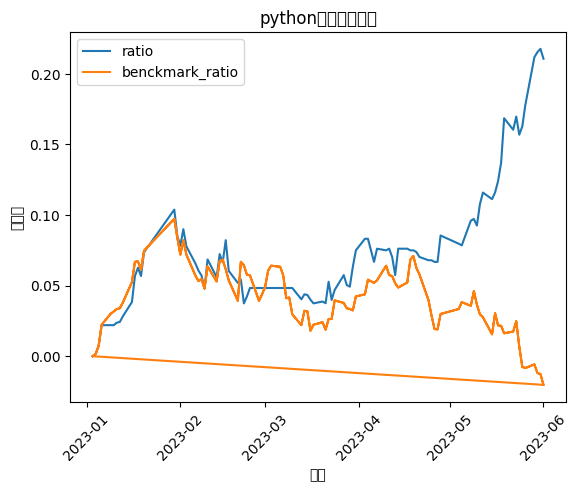

In [6]:

# 初始化函数，设定基准等等
def initialize(context):
    # 设定002624作为基准
    set_bench_mark('159919')
    g.stock_pool = ['159919', '510500', '159915', '513100']
    g.stock_num = 1 #买入评分最高的前stock_num只股票
    g.momentum_day = 29 #最新动量参考最近momentum_day的

    #rsrs择时参数
    g.ref_stock = '159919' #用ref_stock做择时计算的基础数据
    g.N = 18 # 计算最新斜率slope，拟合度r2参考最近N天
    g.M = 600 # 计算最新标准分zscore，rsrs_score参考最近M天
    g.score_threshold = 0.7 # rsrs标准分指标阈值
    #ma择时参数
    g.mean_day = 20 #计算结束ma收盘价，参考最近mean_day
    g.mean_diff_day = 3 #计算初始ma收盘价，参考(mean_day + mean_diff_day)天前，窗口为mean_diff_day的一段时间
    g.slope_series = initial_slope_series()[:-1] # 除去回测第一天的slope，避免运行时重复加入


# 框架主体函数
def run():
    # 创建收益数据表
    plt_df = pd.DataFrame(index=pd.to_datetime(context.date_range), columns=['value'])
    # 初始资金
    init_value = context.portfolio.available_cash
    initialize(context)
    last_price = {}
    
    # 模拟每个bar运行
    for dt in context.date_range:

        dt = np.datetime_as_string(dt).split('T')[0]  # 提取日期部分
        dt = datetime.datetime.strptime(dt, '%Y-%m-%d').date()
        context.dt = dt

        handle_data(context)
        
        value = context.portfolio.available_cash

        # 遍历每支股票计算股票价值
        for stock, position in context.portfolio.positions.items():
            today_data = get_today_data(stock)
            # 停牌
            if len(today_data) == 0:
                # 停牌前一交易日股票价格
                p = last_price[stock]
            else:
                p = today_data['open'].values[0]
                # 存储为停牌前一交易日股票价格
                last_price[stock] = p
            value += p * context.portfolio.positions[stock].total_amount
        plt_df.loc[dt, 'value'] = value

    print(plt_df)
    # fname 为你的字体库路径和字体名
    # 图形中文显示， Matplotlib 默认情况不支持中文
    # zhfont1 = matplotlib.font_manager.FontProperties(fname="SourceHanSansSC-Bold.otf")

    # 收益率
    plt_df['ratio'] = (plt_df['value'] - init_value) / init_value
    bm_df = attribute_daterange_history(context.benchmark, context.start_date, context.end_date)
    bm_init = bm_df['open'][0]
    # 基准收益率
    plt_df['benckmark_ratio'] = (bm_df['open'] - bm_init) / bm_init
    plt.title("python简单量化框架")
    # 绘制收益率曲线
    plt.plot(plt_df['ratio'], label="ratio")
    # 绘制基准收益率曲线
    plt.plot(plt_df['benckmark_ratio'], label="benckmark_ratio")
    # fontproperties 设置中文显示用字体，fontsize 设置字体大小
    plt.xlabel("日期")
    plt.ylabel("收益率")
    # x坐标斜率
    plt.xticks(rotation=46)
    # 添加图注
    plt.legend()
    # 显示
    plt.show()

run()

In [7]:
# 测试

etf_real_time_df = ak.fund_etf_spot_em()
print(etf_real_time_df)
etf_code_list = etf_real_time_df['代码'].to_list()
etf_name_list = etf_real_time_df['名称'].to_list()

etf_dict = dict(zip(etf_name_list, etf_code_list))
print(etf_dict)

etf_dict['纳指ETF']

         代码         名称    最新价    涨跌额   涨跌幅        成交量           成交额    开盘价  \
0    562900    现代农业ETF  0.808  0.023  2.93   282067.0  2.249882e+07  0.789   
1    159865      养殖ETF  0.689  0.019  2.84  7304810.0  5.000287e+08  0.669   
2    159867      畜牧ETF  0.691  0.019  2.83  1322684.0  9.074270e+07  0.671   
3    516670    畜牧养殖ETF  0.735  0.019  2.65   700462.0  5.121475e+07  0.717   
4    516760      养殖ETF  0.720  0.018  2.56   527791.0  3.791252e+07  0.702   
..      ...        ...    ...    ...   ...        ...           ...    ...   
767  588290  科创芯片ETF华安  1.252 -0.033 -2.57   918394.0  1.155922e+08  1.274   
768  159869      游戏ETF  1.460 -0.040 -2.67  4431941.0  6.447213e+08  1.487   
769  516010      游戏ETF  1.442 -0.043 -2.90  1297835.0  1.863205e+08  1.486   
770  159855      影视ETF  0.998 -0.037 -3.57   149285.0  1.493534e+07  1.029   
771  516620      影视ETF  1.104 -0.041 -3.58   163244.0  1.799780e+07  1.138   

       最高价    最低价     昨收    换手率        流通市值         总市值  
0    

'159941'

In [8]:
# # 克隆自聚宽文章：https://www.joinquant.com/post/29046
# # 标题：年化28%，回撤17%的中美轮动+行业轮动策略
# # 作者：天然15

# # 导入函数库
# from jqdata import *
# import copy

# # 初始化函数，设定基准等等
# def initialize(context):
#     # 设定沪深300作为基准
#     set_benchmark('000300.XSHG')
#     # 开启动态复权模式(真实价格)
#     set_option('use_real_price', True)
#     # 输出内容到日志 log.info()
#     log.info('初始函数开始运行且全局只运行一次')
#     # 过滤掉order系列API产生的比error级别低的log
#     log.set_level('order', 'error')
#     # 设置手续费是：买入时佣金万分之一，卖出时佣金万分之一,无印花税, 每笔交易佣金最低扣0块钱
#     set_order_cost(OrderCost( open_commission=0.0001, close_commission=0.0001,close_tax=0, min_commission=0), type='fund')
#     # 设置滑点
#     set_slippage(FixedSlippage(0.01))
#     #超高风险：创业板 [8,-2]
#     g.super_high = '159915.XSHE' 
#     #高风险：行业混合：消费+医疗+科技+新兴成指+深证100 [5,-5]
#     g.high=['162605.XSHE','512010.XSHG','161903.XSHE','163415.XSHE','161005.XSHE'] 
#     #中风险：纳指(513100.XSHG)
#     g.medium='513100.XSHG'
#     #低风险：纯债-易基综债(161119.XSHE) /货基-华宝添益(511990.XSHG)
#     g.low='511990.XSHG'
#     # 开盘时运行
#     run_daily(market_open, time='open')

# ## 开盘时运行函数
# def market_open(context):
#     check_growth(context)
#     check_LOF(context)

# ## 检查创业板涨幅
# def check_growth(context):
#     target_value=context.portfolio.total_value/2
#     fund=g.super_high
#     backup=g.medium
#     rate20=get_rate20(fund)
#     # 若20日涨幅高于7%, 则买入创业板
#     if rate20 > 0.07 and fund not in context.portfolio.positions:
#         # 如果持有纳指，则卖出
#         if backup in context.portfolio.positions:
#             order_target_value(backup, 0)
#         # 买入创业板
#         order_target_value(fund,target_value)
#     # 若20日涨幅低于0%, 则卖出创业板
#     elif rate20 < 0 and fund in context.portfolio.positions:
#         # 卖出创业板
#         order_target_value(fund, 0)
#     # 如果当前未持有创业板和纳指，则买入纳指
#     if fund not in context.portfolio.positions and backup not in context.portfolio.positions: 
#         # 买入纳指
#         order_target_value(backup, target_value)

# ## 检查LOF涨幅
# def check_LOF(context):
#     target_value=context.portfolio.total_value/2
#     backup=g.low
#     for fund in g.high:
#         rate20=get_rate20(fund)
#         # 若20日涨幅高于5%, 则买入
#         if rate20 > 0.05 and fund not in context.portfolio.positions:
#             # # 如果持有债基，则卖出
#             # if backup in context.portfolio.positions:
#             #     order_target_value(backup, 0)
#             # 买入LOF基金  
#             order_target_value(fund, target_value/len(g.high))
#         # 若20日涨幅低于-5%, 则卖出
#         elif rate20 < -0.05 and fund in context.portfolio.positions:
#             # 卖出LOF基金
#             order_target_value(fund, 0)
#     # # 剩余资金，全部买入债基，检查是否大于1000，是为了防止开仓数量小于100导致提示错误
#     # if context.portfolio.available_cash>1000:
#     #     # 买入债基
#     #     order_value(g.low, context.portfolio.available_cash)

# # 获取昨日的20日涨幅
# def get_rate20(fund):
#     # 获取过去21日的收盘价
#     close_data = get_bars(fund, count=21, unit='1d', fields=['date','close'])
#     # 获取21日前的价格
#     close_before_21 = close_data['close'][0]
#     # 获取昨日的价格
#     close_before_1 = close_data['close'][-1]
#     # 取得昨日的20日涨幅
#     rate20=close_before_1/close_before_21-1
#     return rate20